DataFrame contains NaN values: False


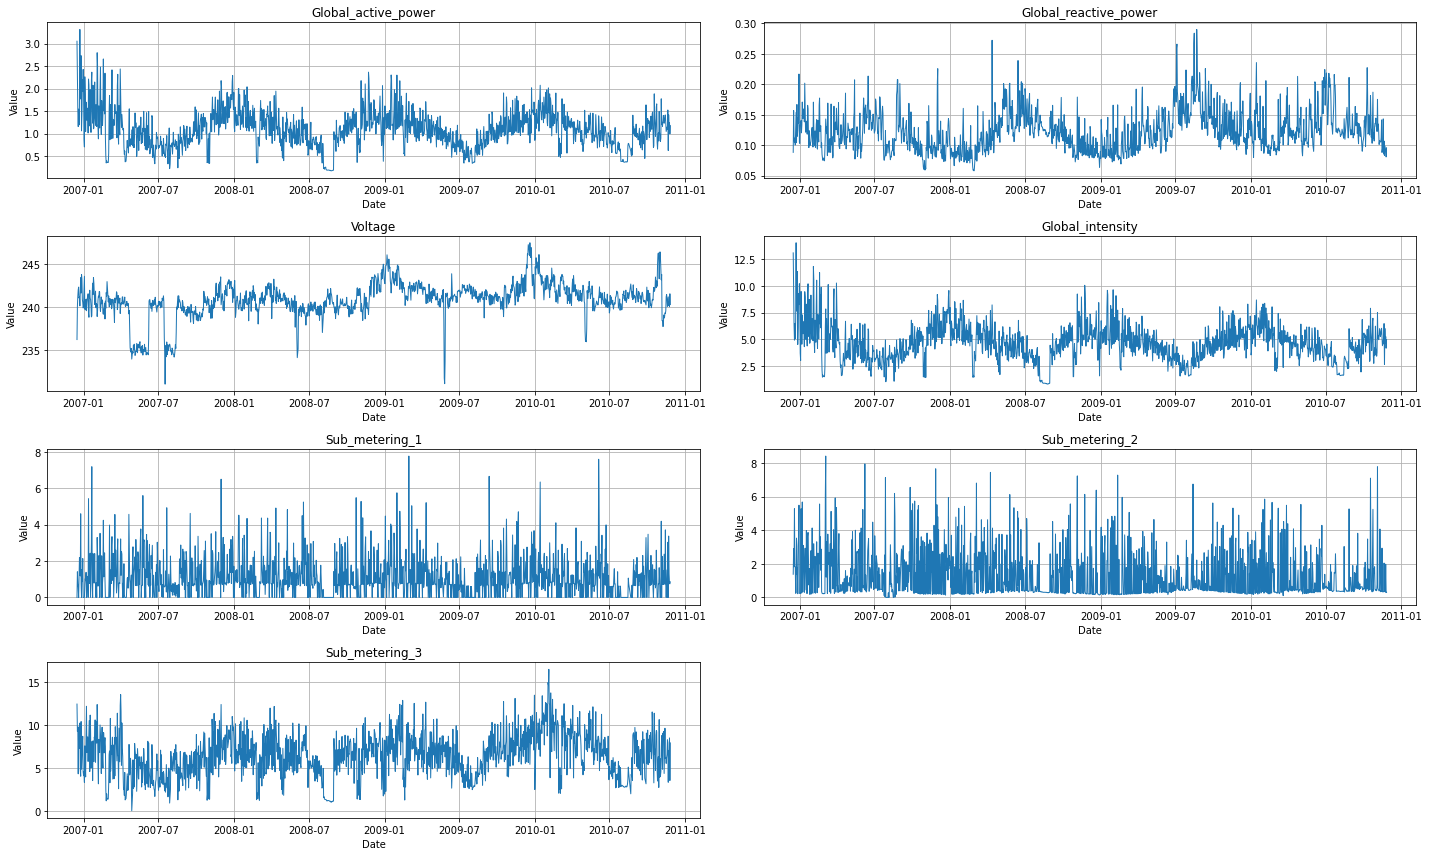

In [1]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
from sklearn.preprocessing import StandardScaler
torch.manual_seed(123)

dataset_file = 'household_power_consumption.txt'
data = pd.read_csv(dataset_file, sep=';',
                 parse_dates={'dt' : ['Date', 'Time']}, infer_datetime_format=True,
                 low_memory=False, na_values=['nan','?'], index_col='dt')
data=data.dropna()
# Resample the data to have one value per day
daily_data = data.resample('D').mean()
daily_data = daily_data.dropna()
has_nans = daily_data.isna().any().any()

print(f"DataFrame contains NaN values: {has_nans}")
# Plot each time series
plt.figure(figsize=(20, 12))
for i, col in enumerate(daily_data.columns):
    plt.subplot(4, 2, i+1)
    plt.plot(daily_data.index, daily_data[col],linewidth=1)
    plt.title(col)
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.grid(True)
plt.tight_layout()
plt.show()

In [2]:
time_series = daily_data.values
ts_train = time_series[:1000]
ts_test = time_series[1000:]
scaler = StandardScaler()
scaler.fit(ts_train)
#time_series = torch.from_numpy(time_series).float()
print(time_series.shape)

(1433, 7)


In [3]:
# Define the linear autoregression model
input_dim = 70  # Number of input values
output_dim = 7  # Number of output values
model = nn.Linear(input_dim, output_dim)

#x_train = torch.from_numpy(ts_train[:-3]).float()
y_train = torch.from_numpy(ts_train[12:]).float()
#x_test = torch.from_numpy(ts_test[:-3]).float()
y_test = torch.from_numpy(ts_test[12:]).float()



x_train = torch.from_numpy(scaler.transform(ts_train[:-3])).float()
x_test = torch.from_numpy(scaler.transform(ts_test[:-3])).float()



# Reshape the input data to have 3 values in each row
x_train = x_train.unfold(0, 10, 1).reshape(-1, 70)
x_test = x_test.unfold(0, 10, 1).reshape(-1, 70)



print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
# Define the loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

# Train the model
num_epochs = 40000
losses = []

for epoch in range(num_epochs):
    outputs = model(x_train)
    loss = criterion(outputs, y_train)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if (epoch + 1) % 1000 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
        
# Generate predictions from the trained model
predicted = model(x_test).detach().numpy()
print(predicted.shape)


torch.Size([988, 70])
torch.Size([988, 7])
torch.Size([421, 70])
torch.Size([421, 7])
Epoch [1000/40000], Loss: 29.1031
Epoch [2000/40000], Loss: 1.6165
Epoch [3000/40000], Loss: 1.4667
Epoch [4000/40000], Loss: 1.4467
Epoch [5000/40000], Loss: 1.4383
Epoch [6000/40000], Loss: 1.4343
Epoch [7000/40000], Loss: 1.4323
Epoch [8000/40000], Loss: 1.4312
Epoch [9000/40000], Loss: 1.4306
Epoch [10000/40000], Loss: 1.4303
Epoch [11000/40000], Loss: 1.4300
Epoch [12000/40000], Loss: 1.4299
Epoch [13000/40000], Loss: 1.4298
Epoch [14000/40000], Loss: 1.4297
Epoch [15000/40000], Loss: 1.4296
Epoch [16000/40000], Loss: 1.4296
Epoch [17000/40000], Loss: 1.4296
Epoch [18000/40000], Loss: 1.4295
Epoch [19000/40000], Loss: 1.4295
Epoch [20000/40000], Loss: 1.4295
Epoch [21000/40000], Loss: 1.4294
Epoch [22000/40000], Loss: 1.4294
Epoch [23000/40000], Loss: 1.4294
Epoch [24000/40000], Loss: 1.4294
Epoch [25000/40000], Loss: 1.4293
Epoch [26000/40000], Loss: 1.4293
Epoch [27000/40000], Loss: 1.4293
Epoc

In [4]:
import numpy as np
np.set_printoptions(suppress=True)


In [5]:
predicted.shape

(421, 7)

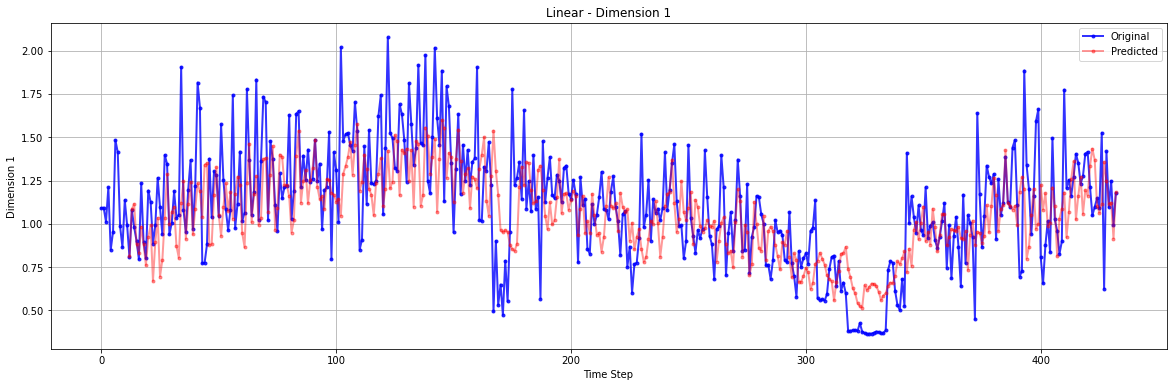

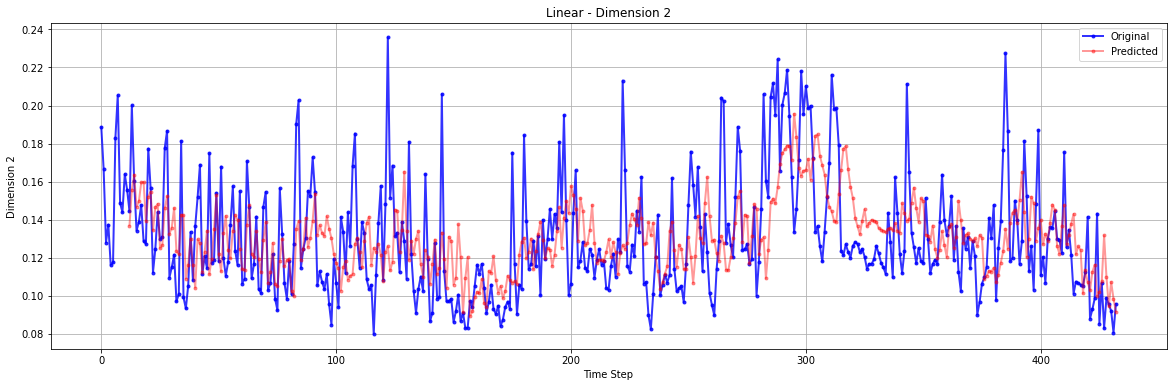

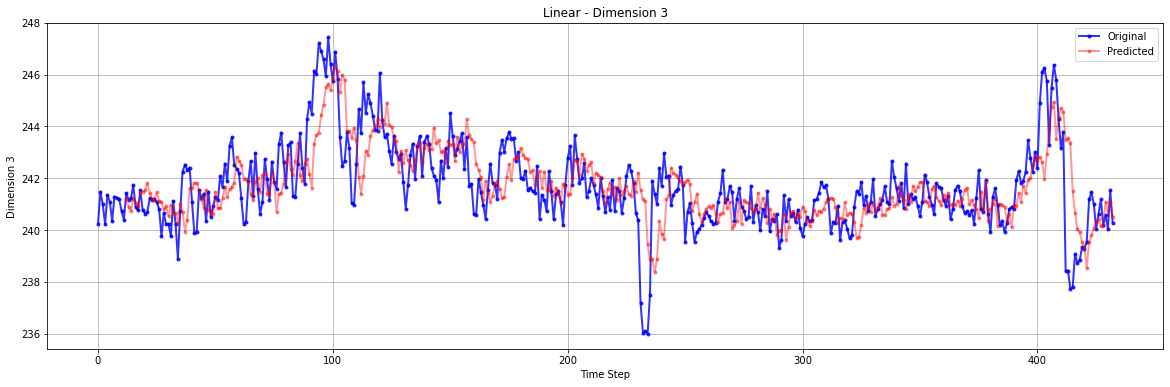

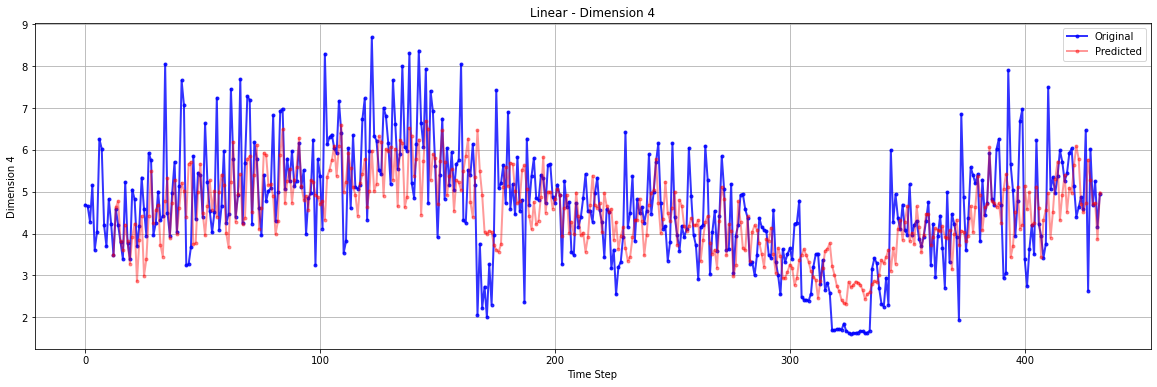

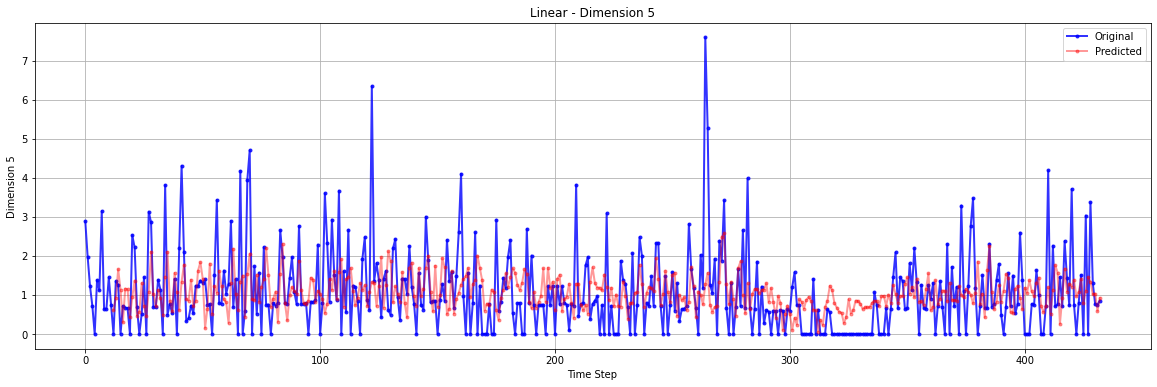

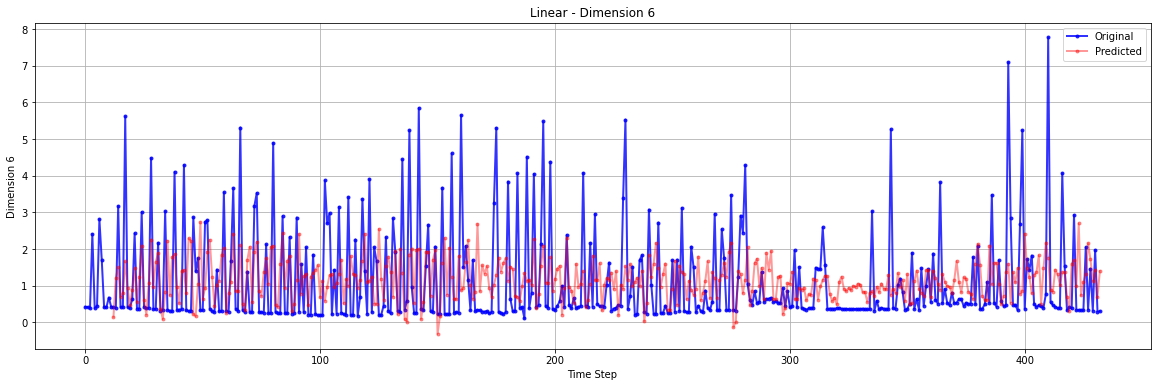

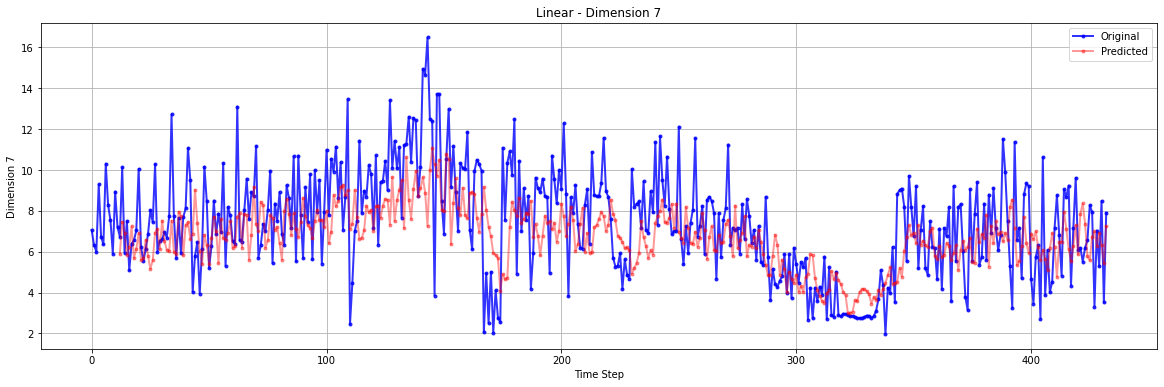

In [6]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(ts_test).float()[:, dim], color='blue', label='Original', linewidth=2,marker='.',alpha=0.8)
    plt.plot(range(12, len(ts_test)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=0.4,marker='.')
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'Linear - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [7]:
# Calculate MSE
mse = torch.mean((torch.from_numpy(predicted) - y_test)**2,dim=0)
# Calculate MAE
mae = torch.mean(torch.abs(torch.from_numpy(predicted) - y_test),dim=0)
print('Metrics for Original Prediction')
for i in range(7):
    print(f"Dimension {i+1}:")
    print(f"MSE: {mse[i].item():.4f}")
    print(f"MAE: {mae[i].item():.4f}")
    print()

Metrics for Original Prediction
Dimension 1:
MSE: 0.0722
MAE: 0.2061

Dimension 2:
MSE: 0.0008
MAE: 0.0219

Dimension 3:
MSE: 1.6881
MAE: 0.9311

Dimension 4:
MSE: 1.2541
MAE: 0.8582

Dimension 5:
MSE: 1.0654
MAE: 0.7571

Dimension 6:
MSE: 1.7547
MAE: 0.9765

Dimension 7:
MSE: 5.1484
MAE: 1.8086



In [8]:
def fgsm_attack(data, epsilon, grad):
    sign_grad = grad.sign()
    perturbed_data = data + epsilon * sign_grad
    return perturbed_data
x_test.requires_grad = True
outputs = model(x_test)        
loss = criterion(outputs, y_test)
loss.backward(retain_graph=True)
data_grad = x_test.grad.data

In [9]:
perturbed_data = fgsm_attack(x_test, 0.2, data_grad)
perturbed_predicted = model(perturbed_data).detach().numpy()
print(perturbed_predicted.shape)
# Calculate MSE
mse = torch.mean((torch.from_numpy(perturbed_predicted) - y_test)**2,dim=0)
# Calculate MAE
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted) - y_test),dim=0)
print('Metrics for on_FGSM Prediction')
for i in range(7):
    print(f"Dimension {i+1}:")
    print(f"MSE: {mse[i].item():.4f}")
    print(f"MAE: {mae[i].item():.4f}")
    print()

(421, 7)
Metrics for on_FGSM Prediction
Dimension 1:
MSE: 0.1623
MAE: 0.3397

Dimension 2:
MSE: 0.0013
MAE: 0.0277

Dimension 3:
MSE: 3.3698
MAE: 1.4528

Dimension 4:
MSE: 3.1386
MAE: 1.5257

Dimension 5:
MSE: 1.7734
MAE: 1.0138

Dimension 6:
MSE: 3.0506
MAE: 1.3164

Dimension 7:
MSE: 12.2774
MAE: 3.0651



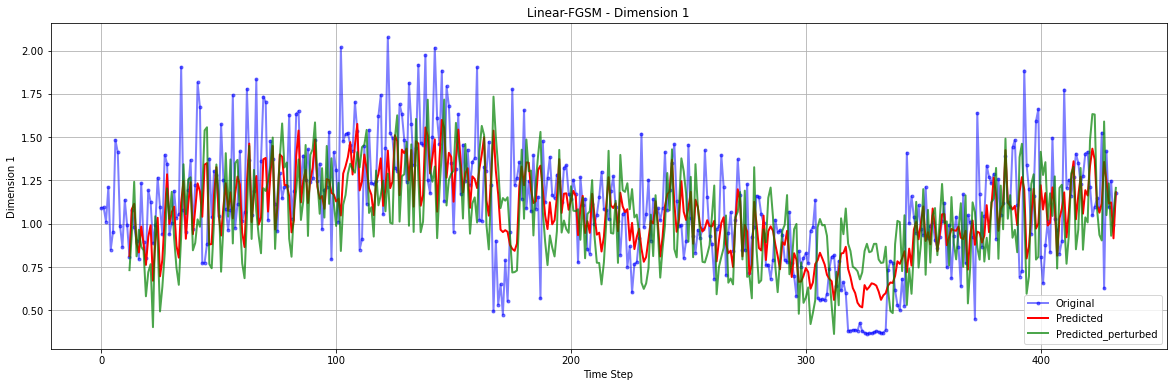

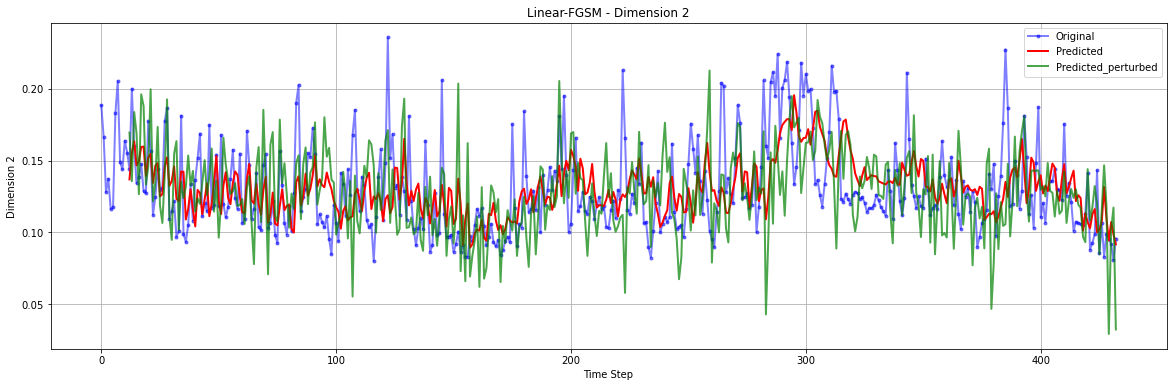

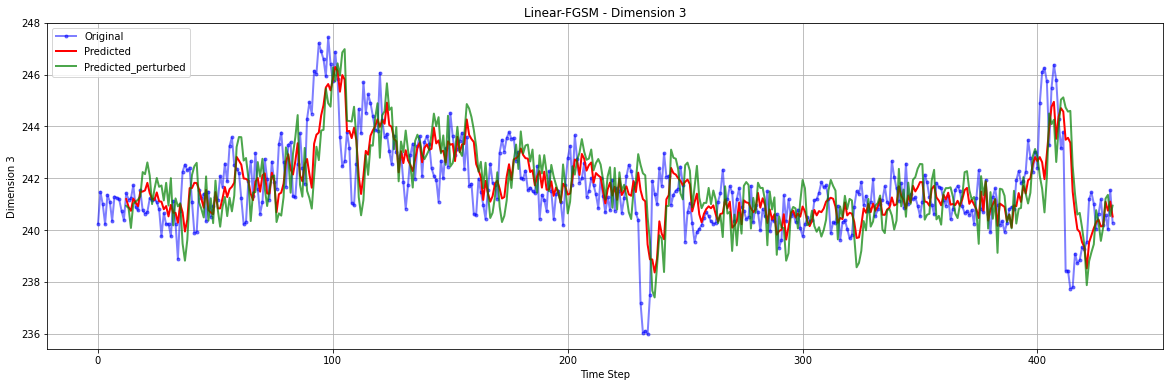

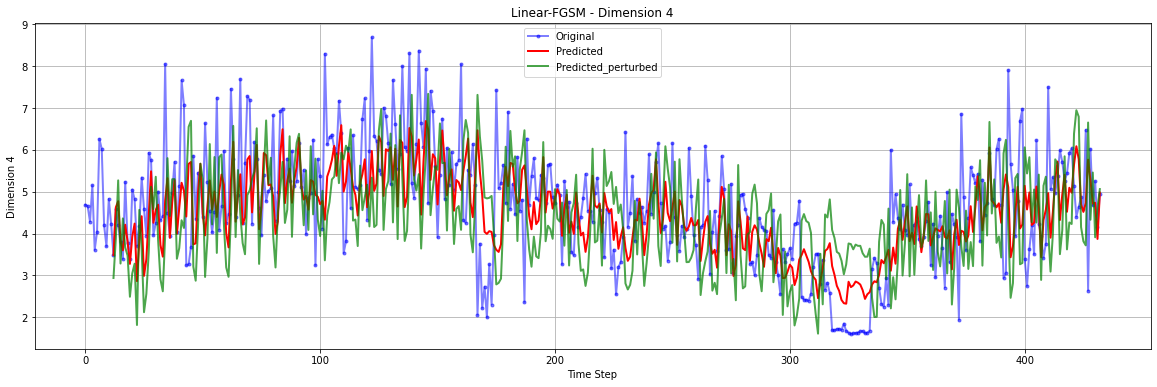

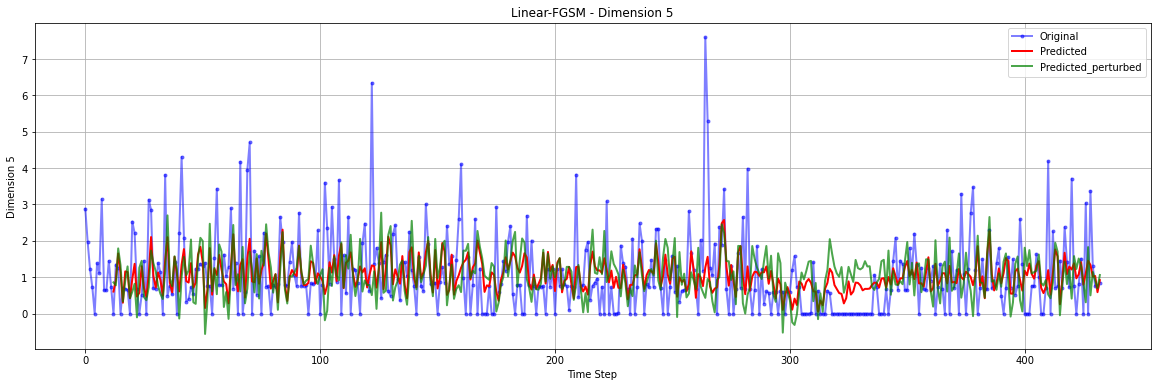

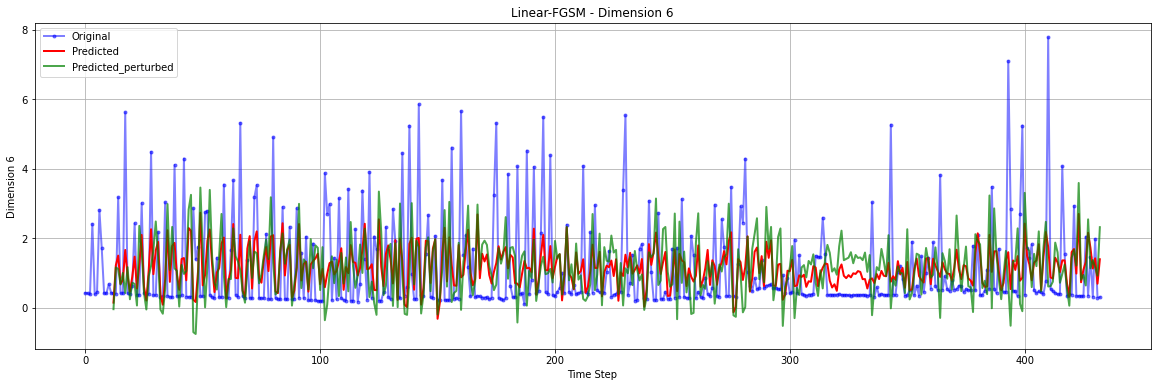

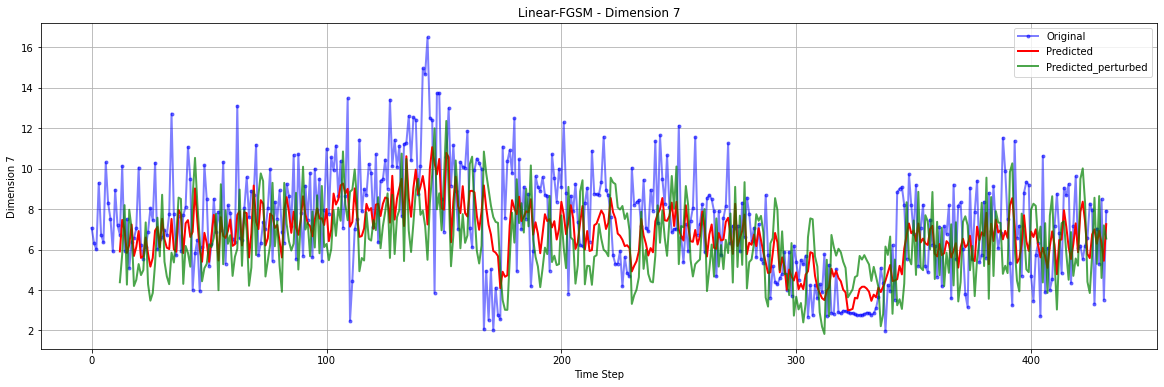

In [10]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(ts_test).float()[:, dim], color='blue', label='Original', linewidth=2,alpha=0.5,marker='.')
    plt.plot(range(12, len(ts_test)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=1)
    plt.plot(range(12, len(ts_test)), perturbed_predicted[:, dim], color='green', label='Predicted_perturbed', linewidth=2, alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'Linear-FGSM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [11]:
# BIM attack
def bim(X, Y, model, epsilon, alpha, I):
    perturbed_data = X.clone().detach().requires_grad_(True)
    for t in range(I):
        model.zero_grad()
        outputs = model(perturbed_data)
        loss = criterion(outputs, Y)
        loss.backward(retain_graph=True)
        sign_grad = perturbed_data.grad.data.sign()
        perturbed_data = perturbed_data + alpha * sign_grad
        perturbed_data = torch.clip(perturbed_data, X - epsilon, X + epsilon)
        perturbed_data = perturbed_data.detach().requires_grad_(True)
    return perturbed_data

perturbed_data = bim(x_test, y_test, model, epsilon=0.2, alpha=0.002, I=200)
print(perturbed_data.shape)
# Generate predictions from the perturbed data
perturbed_x = perturbed_data.float()
perturbed_predicted = model(perturbed_x).detach().numpy()
print(perturbed_predicted.shape)
# Calculate MSE
mse = torch.mean((torch.from_numpy(perturbed_predicted) - y_test)**2,dim=0)
# Calculate MAE
mae = torch.mean(torch.abs(torch.from_numpy(perturbed_predicted) - y_test),dim=0)
print('Metrics for on_BIM Prediction')
for i in range(7):
    print(f"Dimension {i+1}:")
    print(f"MSE: {mse[i].item():.4f}")
    print(f"MAE: {mae[i].item():.4f}")
    print()

torch.Size([421, 70])
(421, 7)
Metrics for on_BIM Prediction
Dimension 1:
MSE: 0.1681
MAE: 0.3527

Dimension 2:
MSE: 0.0011
MAE: 0.0251

Dimension 3:
MSE: 3.2356
MAE: 1.4270

Dimension 4:
MSE: 3.2323
MAE: 1.5769

Dimension 5:
MSE: 1.7055
MAE: 0.9811

Dimension 6:
MSE: 2.8831
MAE: 1.2558

Dimension 7:
MSE: 12.7837
MAE: 3.1666



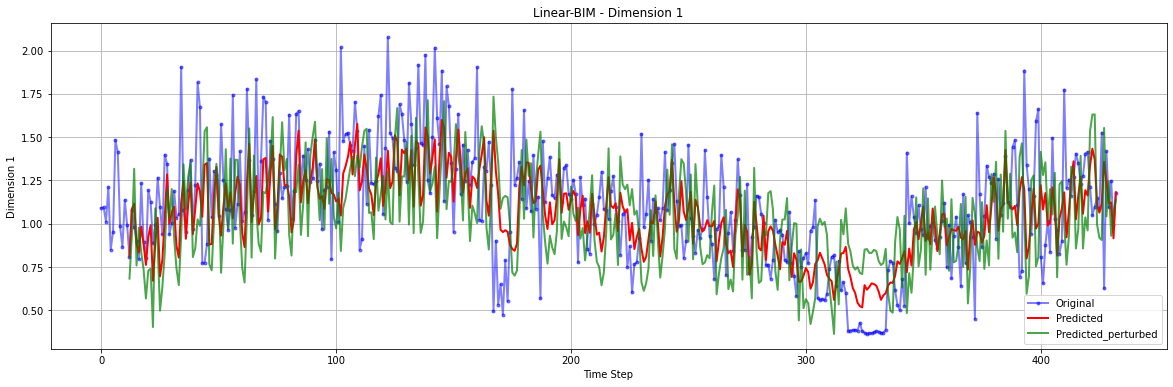

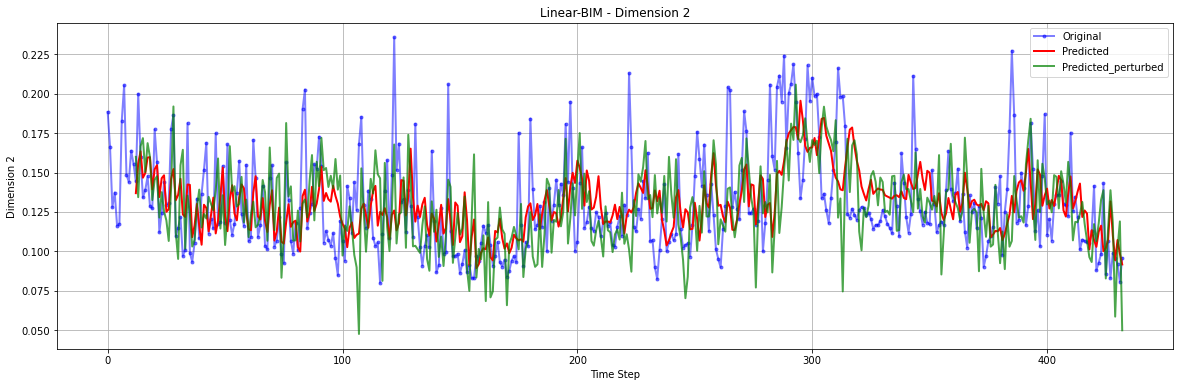

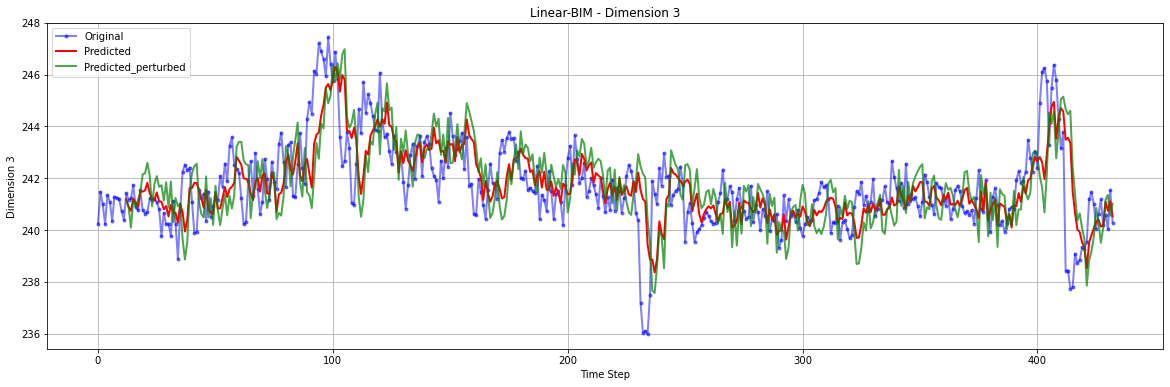

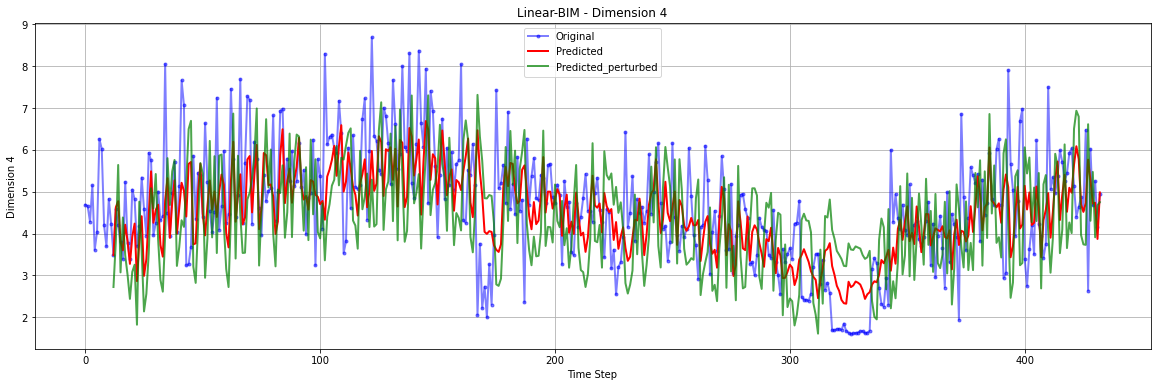

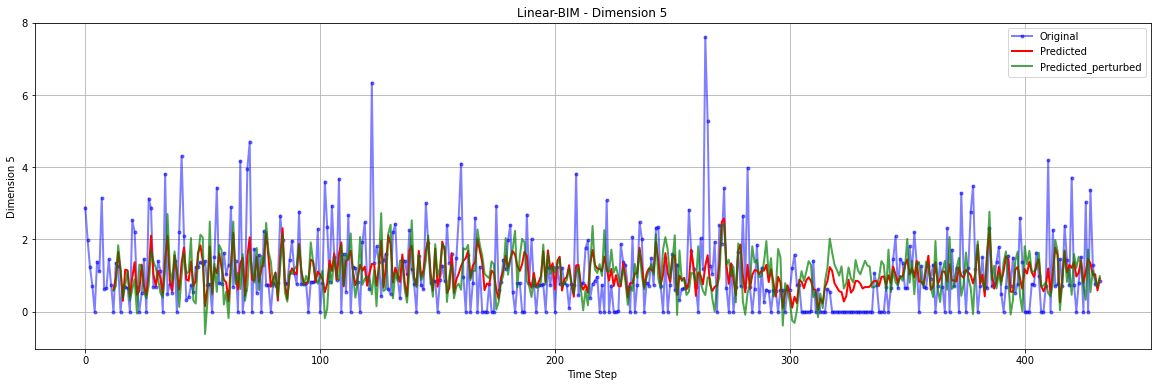

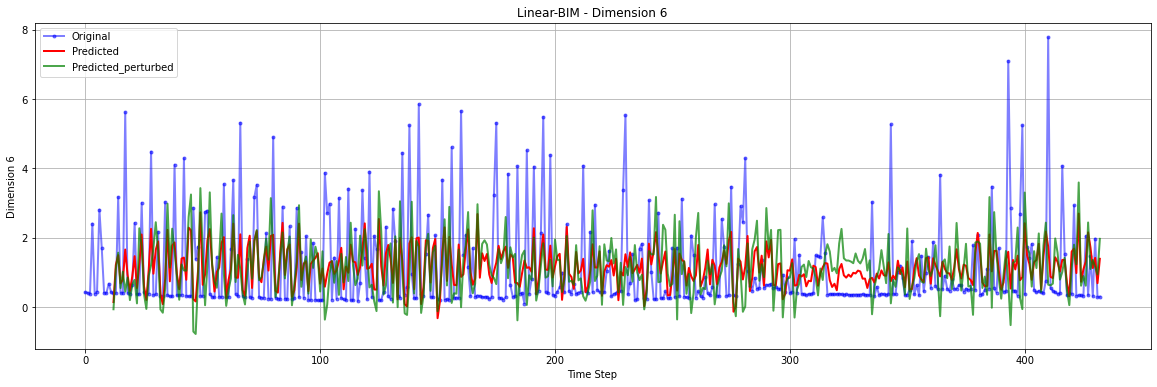

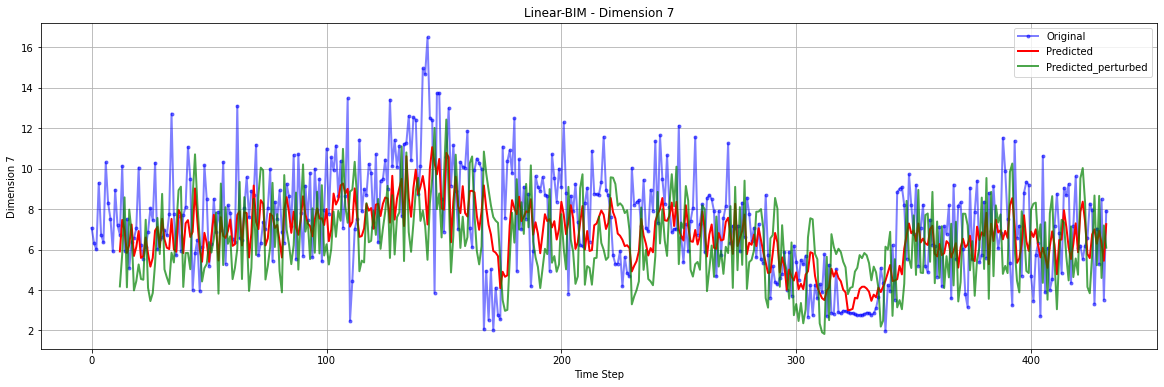

In [12]:
for dim in range(7):
    plt.figure(figsize=(20, 6))
    plt.plot(torch.from_numpy(ts_test).float()[:, dim], color='blue', label='Original', linewidth=2,alpha=0.5,marker='.')
    plt.plot(range(12, len(ts_test)), predicted[:, dim], color='red', label='Predicted', linewidth=2, alpha=1)
    plt.plot(range(12, len(ts_test)), perturbed_predicted[:, dim], color='green', label='Predicted_perturbed', linewidth=2, alpha=0.7)
    plt.xlabel('Time Step')
    plt.ylabel(f'Dimension {dim+1}')
    plt.title(f'Linear-BIM - Dimension {dim+1}')
    plt.legend()
    plt.grid(True)
    plt.show()